In [1]:
LANGUAGE = 'EN' # options are 'EN' or 'PT'
PI = '3141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724587006606315588174881520920962829254091715364367892590360011330530548820466521384146951941511609433057270365759591953092186117381932611793105118548074462379962749567351885752724891227938183011949129833673362440656643086021394946395224737190702179860943702770539217176293176752384674818467669405132000568127145263560827785771342757789609173637178721468440901224953430146549585371050792279689258923542019956112129021960864034418159813629774771309960518707211349999998372978049951059731732816096318595024459455346908302642522308253344685035261931188171010003137838752886587533208381420617177669147303598253490428755468731159562863882353787593751957781857780532171226806613001927876611195909216420198'

In [2]:
import numpy as np
import collections

def convert_word_to_number(word):
    # max of two letters per number for now
    numbers = []
    skip_one = False 
    pos = 0
    for first_letter, second_letter in zip(word[:-1], word[1:]):
        pos += 1
        if skip_one:
            skip_one = False
            continue
        two_letters = first_letter+second_letter
        if two_letters in letters_to_number.keys(): # two letters takes precedent over 1 letter
            numbers.append(letters_to_number[two_letters])
            skip_one = True # if we find a two letter match, skip next letter so that it does not fit anything else
        else:
            if first_letter in letters_to_number.keys():
                numbers.append(letters_to_number[first_letter])
            if pos == len(word) - 1 and second_letter in letters_to_number.keys():
                numbers.append(letters_to_number[second_letter])
        
    return ''.join(numbers)

def solution_summary(number, solution, show_solution=False):
    if show_solution:
        print('Number: %s' % number)
        print('Solution: %s' % ', '.join([ '%s (%s)' % (word, word_numbers[word]) for word in solution]))
        print()
    print('Number of digits: %d' % len(number))
    print('Number of words: %d' % len(solution))
    print('Average word length: %.2f' % np.mean([len(word_numbers[word]) for word in solution]))
    print('Number of repeated words: %.2f' % (len(solution) - len(np.unique(solution))))
    counts = collections.Counter(solution)
    print('Repeated words used: %s' % ', '.join([ '%s (x%d)' % (word,count) for word,count in counts.items() if count > 1]))

In [3]:
word_scores = {}

# open list of words and create dict so we can navigate faster
if LANGUAGE == 'EN':
    noun_frequency_file = "nouns/en/nounlist_frequency.csv"

    # from Derren Brown's - Trick of the Mind
    letters_to_number = {
        's': '0',
        'z': '0',
        'l': '1',
        'n': '2',
        'm': '3',
        'r': '4',
        'f': '5',
        'v': '5',
        'b': '6',
        'p': '6',
        't': '7',
        'ch': '8',
        'sh': '8',
        'j': '8',
        'g': '9'
    }
elif LANGUAGE == 'PT':
    noun_frequency_file = "nouns/pt/nounlist_frequency.csv"
    
    letters_to_number = {
        's': '0',
        'z': '0',
        'l': '1',
        'd': '2',
        'r': '3',
        'c': '4',
        'q': '4',
        'n': '5',
        'b': '6',
        'p': '6',
        't': '7',
        'ch': '8',
        'x': '8',
        'v': '9'
    }

with open(noun_frequency_file,'r') as f:
    for line in f:
        word, score = line.split(',')[:2]
        word_scores[word] = int(score)

word_numbers = {word: convert_word_to_number(word) for word in word_scores.keys()}
word_numbers = {word: numbers for word, numbers in word_numbers.items() if numbers} # remove words that can't be converted to numbers

# Dumb solution
Just tries to fit any word from left to right.

In [4]:
# pick first and go!
def dumb_get_first_solution(big_string, current_list=[]):
    if len(big_string) == 0:
        return current_list
    
    for word, number_string in word_numbers.items():
        if big_string.startswith(number_string):
            return dumb_get_first_solution(big_string[len(number_string):], current_list + [word])

# Basic solution
Tries to fit best possible words one at a time from left to right.

In [5]:
# computes score of word taken into account words already picked
WEIGHT_OF_SIZE = 20
WEIGHT_OF_POPULARITY = 5
WEIGHT_OF_PENALTY = 100
def compute_word_score(word, already_picked):
    elements = {
        'size': {
            'value': 1+len(word_numbers[word]),
            'weight': WEIGHT_OF_SIZE
        },
        'popularity': {
            'value': np.log(word_scores[word]),
            'weight': WEIGHT_OF_POPULARITY
        },
        'alreadypicked_penalty': {
            'value': 1 if word in already_picked else 10,
            'weight': WEIGHT_OF_PENALTY 
        }
    }
    numerator = [element_values['weight']*np.log(element_values['value']) for element_name, element_values in elements.items()]
    denominator = [element_values['weight'] for element_name, element_values in elements.items()]
    
    return np.exp(np.sum(numerator)/np.sum(denominator))

# sequential iterative solution - find biggest/popular and continue
def recursive_basic_solution(big_string, current_list=[]):
    if len(big_string) == 0:
        return current_list
    
    max_score = 0
    best_word = ''
    for word, number_string in word_numbers.items():
        if big_string.startswith(number_string):
            score = compute_word_score(word, current_list)
            if score >= max_score:
                max_score = score
                best_word = word
                
    return recursive_basic_solution(big_string[len(word_numbers[best_word]):], current_list + [best_word])

# Full exhaustive search
This function looks up all the combinations of words that fit a number. It first converts words into blocks of numbers that it then tries to fit. This makes it so that two words that convert into the same number do not feature more than once in the solution. Once we have the solution as a sequence of blocks we then convert them back into words taking into account that if the same blocks are present more than once, they should as much as possible be converted to separate words to avoid repetition.

In [6]:
# turns word -> number into number -> words
building_blocks = {}
for word, number_string in word_numbers.items():
    if number_string in building_blocks:
        building_blocks[number_string].append(word)
    else:
        building_blocks[number_string] = [word]

# test all combinations (uses number blocks to lower search space)
def exaustive_recursive_solution(current_path, remaining_string, final_paths):
    if len(remaining_string) == 0:
        final_paths.append(current_path)
    else:
        for number_string in building_blocks.keys():
            if remaining_string.startswith(number_string):
                final_paths = exaustive_recursive_solution(current_path + [number_string], remaining_string[len(number_string):], final_paths)                
    return final_paths

# turns list of blocks into best words so they don't repeat and are the most popular
def convert_block_solution_to_best_word_solution(solution):
    constructed_solution = []
    for number_string in solution:
        possible_words = building_blocks[number_string]
        possible_words_sorted = sorted(possible_words, key=lambda x: (constructed_solution.count(x), -word_scores[x]))
        constructed_solution.append(possible_words_sorted[0])            
    return constructed_solution

# turns list of words into score (penalizes repeated words)
def compute_solution_score(words):
    denominator = []
    numerator = []
    for word in words:
        numerator.append(WEIGHT_OF_SIZE*np.log(len(word_numbers[word])+1))
        denominator.append(WEIGHT_OF_SIZE)
        
        denominator.append(WEIGHT_OF_POPULARITY*np.log(np.log(word_scores[word])))
        numerator.append(WEIGHT_OF_POPULARITY)
        
        numerator.append(WEIGHT_OF_PENALTY*np.log(1 if word in words else 10))
        denominator.append(WEIGHT_OF_PENALTY)

    return np.exp(np.sum(numerator)/np.sum(denominator))

def full_exaustive_solution(number_string):
    solutions = exaustive_recursive_solution([], number_string, [])
    
    constructed_solutions = []
    for solution in solutions:
        constructed_solutions.append(convert_block_solution_to_best_word_solution(solution))
        
    ordered_solutions = sorted(constructed_solutions, key=lambda x: -compute_solution_score(x))
    return ordered_solutions[0]

## Check when it becomes too much for this to handle it

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b41d40048>,
      dtype=object)

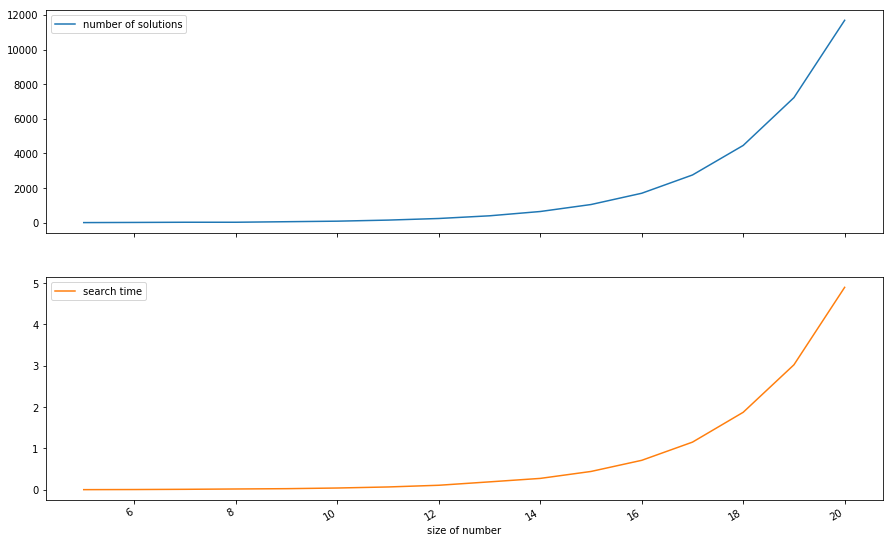

In [7]:
%matplotlib inline
import timeit
x = range(5,21)
y_len = []
y_time = []
for size in x:
    start = timeit.default_timer()
    PI_SAMPLE = PI[:size]
    solutions = exaustive_recursive_solution([], PI_SAMPLE, [])
    y_len.append(len(solutions))
    stop = timeit.default_timer()
    y_time.append(stop - start)

import pandas as pd
df = pd.DataFrame({'size of number': x, 'number of solutions': y_len, 'search time': y_time})
df.plot(x='size of number', subplots =True, figsize=(15,10))

# Divide & Conquer
Since the exhaustive search quickly struggles with large numbers we have to find a way to break big numbers into smaller/computable ones.

In [8]:
MIN_NUMBER_SIZE = 15
PADDING = 5

# returns best possible word that fits in number
def find_best_word(number):
    max_score = 0
    best_word = ''
    for i in range(len(number)):
        subnumber = number[i:]
        for word, number_string in word_numbers.items():
            if subnumber.startswith(number_string):
                score = compute_word_score(word,[])
                if score >= max_score:
                    max_score = score
                    best_word = word
    return best_word

# Divides number if too big and gets best solution for each splitted number
def split_and_solve(number):
    if len(number) > MIN_NUMBER_SIZE:    
        left, middle = number[:MIN_NUMBER_SIZE-5], number[MIN_NUMBER_SIZE-5:MIN_NUMBER_SIZE+5]
        best_word = find_best_word(middle)
        best_digits = word_numbers[best_word]

        middle_left, middle_right = middle.split(best_digits, 1)    
        left = left + middle_left
        rest = number[len(left)+len(best_digits):]

        best_word_solution = full_exaustive_solution(left)
        best_block_solution = [word_numbers[word] for word in best_word_solution]
        
        return best_block_solution + [best_digits] + split_and_solve(rest)        
    else:
        best_word_solution = full_exaustive_solution(number)
        best_block_solution = [word_numbers[word] for word in best_word_solution]
        return best_block_solution

# calls split_and_solve and converts solution into words
def divide_and_conquer_solution(number):
    blocks = split_and_solve(number)
    return convert_block_solution_to_best_word_solution(blocks)

# Putting it to the test

## Starting with a small number (20 digits)

In [9]:
TEST_NUMBER = PI[:20]

In [10]:
%%time
solution = dumb_get_first_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 20
Number of words: 20
Average word length: 1.00
Number of repeated words: 11.00
Repeated words used: home (x4), lead (x2), war (x2), face (x3), high (x3), end (x2), coach (x2)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.9 ms


In [11]:
%%time
solution = recursive_basic_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 20
Number of words: 10
Average word length: 2.00
Number of repeated words: 0.00
Repeated words used: 
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 16.7 ms


In [12]:
%%time
solution = full_exaustive_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 20
Number of words: 10
Average word length: 2.00
Number of repeated words: 0.00
Repeated words used: 
CPU times: user 9.47 s, sys: 20 ms, total: 9.49 s
Wall time: 9.49 s


In [13]:
%%time
solution = divide_and_conquer_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 20
Number of words: 10
Average word length: 2.00
Number of repeated words: 0.00
Repeated words used: 
CPU times: user 760 ms, sys: 0 ns, total: 760 ms
Wall time: 759 ms


## Now 60 digits!

In [14]:
TEST_NUMBER = PI[:60]

In [15]:
%%time
solution = dumb_get_first_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 60
Number of words: 57
Average word length: 1.05
Number of repeated words: 44.00
Repeated words used: home (x9), lead (x3), war (x6), face (x5), high (x10), end (x5), book (x3), coach (x5), city (x5), house (x3)
CPU times: user 0 ns, sys: 10 ms, total: 10 ms
Wall time: 2.27 ms


In [16]:
%%time
solution = recursive_basic_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 60
Number of words: 27
Average word length: 2.22
Number of repeated words: 0.00
Repeated words used: 
CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 42 ms


**Exhaustive would not even finish in this case**

In [17]:
%%time
solution = divide_and_conquer_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 60
Number of words: 26
Average word length: 2.31
Number of repeated words: 1.00
Repeated words used: mocha (x2)
CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.1 s


## Let's take it to the next level!

In [18]:
TEST_NUMBER = PI

In [19]:
%%time
solution = recursive_basic_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 1000
Number of words: 461
Average word length: 2.17
Number of repeated words: 56.00
Repeated words used: gun (x4), movie (x4), mocha (x4), waves (x2), gym (x5), fish (x4), coach (x3), egg (x5), high (x12), music (x2), office (x3), vacuum (x7), fog (x8), museum (x2), fob (x5), shift (x2)
CPU times: user 740 ms, sys: 10 ms, total: 750 ms
Wall time: 750 ms


In [20]:
%%time
solution = divide_and_conquer_solution(TEST_NUMBER)
solution_summary(TEST_NUMBER, solution)

Number of digits: 1000
Number of words: 434
Average word length: 2.30
Number of repeated words: 110.00
Repeated words used: gun (x3), paved (x4), movie (x6), judge (x3), thigh (x3), mocha (x9), carbon (x3), gauva (x9), magic (x2), gym (x3), tv (x5), fish (x5), ogre (x2), wagon (x2), egg (x3), ship (x2), niche (x5), vacuum (x3), toga (x2), squash (x2), gem (x2), suv (x4), omelet (x3), knife (x2), sash (x2), scented (x2), wigwam (x2), chef (x5), fog (x3), leg (x4), fob (x4), cinema (x2), log (x3), squeegee (x3), cabbage (x2), hammock (x5), puma (x2), gown (x2), sego (x3), foam (x2), sofa (x3), leash (x6), bullet (x2), hedgehog (x3), shift (x2), inn (x2), metal (x2), agogo (x2), fig (x2), smock (x2), match (x2)
CPU times: user 47.1 s, sys: 0 ns, total: 47.1 s
Wall time: 47 s
